<a href="https://colab.research.google.com/github/ezrafield/ibm-certificate-final/blob/main/hidden_markov_models_hmms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hidden Markov models

code from 
https://medium.com/@natsunoyuki/hidden-markov-models-with-python-c026f778dfa7

hmmlearn: lib for Hidden Markov models

#### The Gaussian Emissions Model



The Gaussian emissions model assumes that the values in X are generated from multivariate Gaussian distributions (i.e. N-dimensional Gaussians), one for each hidden state. Each multivariate Gaussian distribution is defined by a multivariate mean and covariance matrix.
- covariance_type = “diag” — the covariance matrix for each hidden state is a diagonal matrix, and these matrices may be different.
- covariance_type = “spherical” — the covariance matrix for each hidden state is proportional to the identity matrix, and these matrices may be different.
- covariance_type = “full” — no restrictions placed on the covariance matrices for any of the hidden states.
- covariance_type = “tied” — all hidden states share the same full covariance matrix.

#### Gaussian Mixture Emissions Model


The Gaussian mixture emissions model assumes that the values in X are generated from a mixture of multivariate Gaussian distributions, one mixture for each hidden state. Each multivariate Gaussian distribution in the mixture is defined by a multivariate mean and covariance matrix.
- covariance_type = “diag” —for each hidden state, the covariance matrix for each multivariate Gaussian distribution in the mixture is diagonal, and these matrices may be different.
- covariance_type = “spherical” — for each hidden state, the covariance matrix for each multivariate Gaussian distribution in the mixture is proportional to the identity matrix, and these matrices may be different.
- covariance_type = “full” — no restrictions placed on the covariance matrices for any of the hidden states or mixtures.
- covariance_type = “tied” — for each hidden state, all mixture components use the same full covariance matrix. These matrices may be different between the hidden states, unlike in the Gaussian emission model.

# data

In [4]:
!pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm

base_dir = "https://github.com/natsunoyuki/Data_Science/blob/master/gold/gold/gold_price_usd.csv?raw=True"

data = pd.read_csv(base_dir)

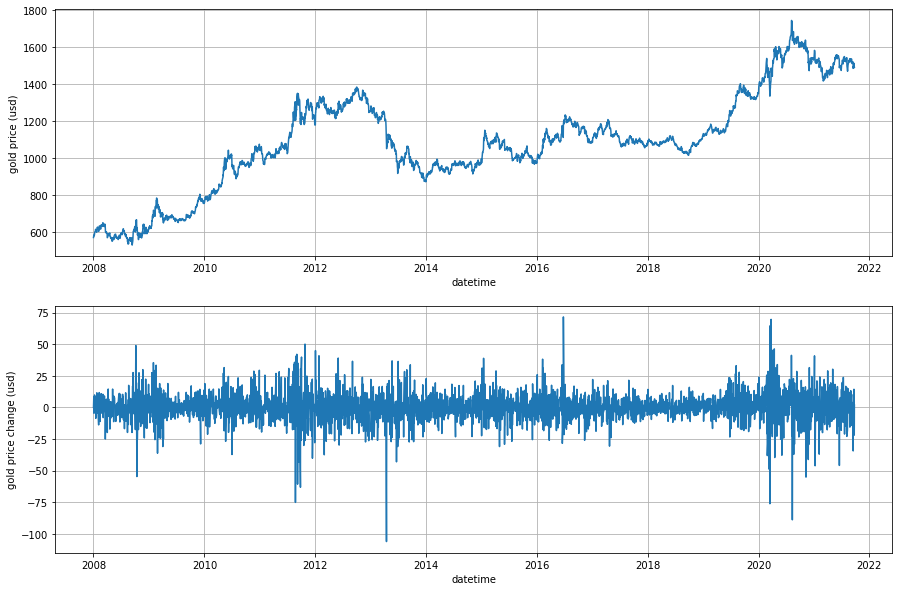

In [6]:
# Convert the datetime from str to datetime object.
data["datetime"] = pd.to_datetime(data["datetime"])

# Determine the daily change in gold price.
data["gold_price_change"] = data["gold_price_usd"].diff()

# Restrict the data to later than 2008 Jan 01.
data = data[data["datetime"] >= pd.to_datetime("2008-01-01")]

# Plot the daily gold prices as well as the daily change.
plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
plt.plot(data["datetime"], data["gold_price_usd"])
plt.xlabel("datetime")
plt.ylabel("gold price (usd)")
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(data["datetime"], data["gold_price_change"])
plt.xlabel("datetime")
plt.ylabel("gold price change (usd)")
plt.grid(True)
plt.show()

# Models

Instead of modeling the gold price directly, we model the daily change in the gold price — this allows us to better capture the state of the market.

 We fit the daily change in gold prices to a Gaussian emissions model with 3 hidden states. 
 
 The reason for using 3 hidden states is that we expect at the very least 3 different regimes in the daily changes — low, medium and high votality.

In [7]:
# Use the daily change in gold price as the observed measurements X.
X = data[["gold_price_change"]].values

In [8]:
# Build the HMM model and fit to the gold price change data.
model = hmm.GaussianHMM(n_components = 3, covariance_type = "diag", n_iter = 50, random_state = 42)
model.fit(X)

GaussianHMM(n_components=3, n_iter=50, random_state=42)

In [9]:
# Predict the hidden states corresponding to observed X.
Z = model.predict(X)
states = pd.unique(Z)

# Results

In [10]:
print("Unique states:", states)
print("\nStart probabilities:", model.startprob_)
print("\nTransition matrix:", model.transmat_)
print("\nGaussian distribution means:", model.means_)
print("\nGaussian distribution covariances:", model.covars_)

Unique states: [1 0 2]

Start probabilities: [9.00876474e-03 9.90991235e-01 1.90652535e-52]

Transition matrix: [[4.71987506e-02 9.52205396e-01 5.95853639e-04]
 [8.12868067e-01 1.35345228e-01 5.17867054e-02]
 [3.95757463e-02 4.27802116e-02 9.17644042e-01]]

Gaussian distribution means: [[0.27897404]
 [0.20658205]
 [0.30620104]]

Gaussian distribution covariances: [[[ 28.11246244]]

 [[ 77.18151421]]

 [[324.43713707]]]


- We find that the model does indeed return 3 unique hidden states. These numbers do not have any intrinsic meaning —which state corresponds to which volatility regime must be confirmed by looking at the model parameters.
- We find that for this particular data set, the model will almost always start in state 0.
- The transition matrix for the 3 hidden states show that the diagonal elements are large compared to the off diagonal elements. This means that the model tends to want to remain in that particular state it is in — the probability of transitioning up or down is not high.
- Finally, we take a look at the Gaussian emission parameters. Remember that each observable is drawn from a multivariate Gaussian distribution. For state 0, the Gaussian mean is 0.28, for state 1 it is 0.21 and for state 2 it is 0.31. The fact that states 0 and 2 have very similar means is problematic — our current model might not be too good at actually representing the data.
- We also have the Gaussian covariances. Note that because our data is 1 dimensional, the covariance matrices are reduced to scalar values, one for each state. For state 0, the covariance is 28.1, for state 1 it is 77.2 and for state 2 it is 324.4. This seems to agree with our initial assumption about the 3 volatility regimes — for low volatility the covariance should be small, while for high volatility the covariance should be very large.

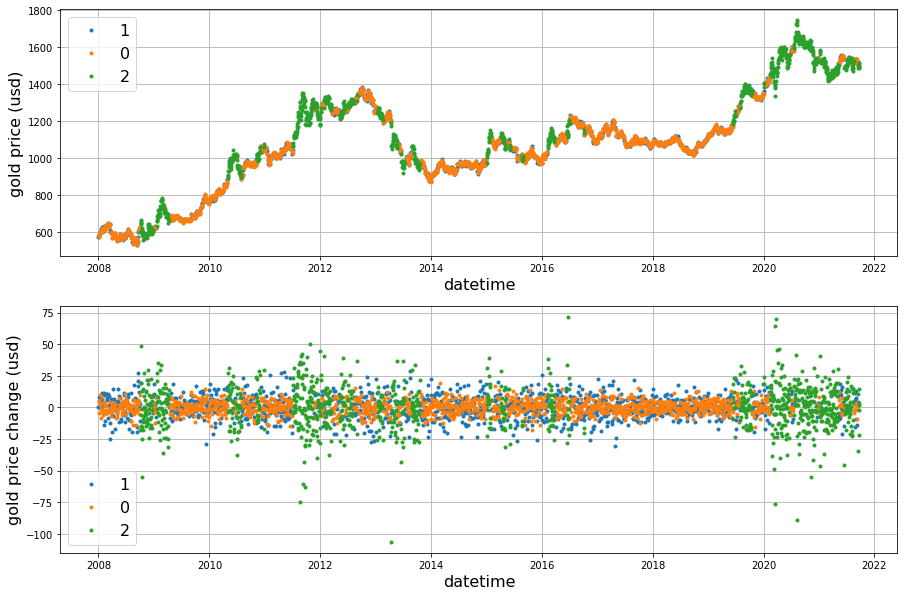

In [11]:
plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
for i in states:
    want = (Z == i)
    x = data["datetime"].iloc[want]
    y = data["gold_price_usd"].iloc[want]
    plt.plot(x, y, '.')
plt.legend(states, fontsize=16)
plt.grid(True)
plt.xlabel("datetime", fontsize=16)
plt.ylabel("gold price (usd)", fontsize=16)
plt.subplot(2,1,2)
for i in states:
    want = (Z == i)
    x = data["datetime"].iloc[want]
    y = data["gold_price_change"].iloc[want]
    plt.plot(x, y, '.')
plt.legend(states, fontsize=16)
plt.grid(True)
plt.xlabel("datetime", fontsize=16)
plt.ylabel("gold price change (usd)", fontsize=16)
plt.show()

- Plotting the model’s state predictions with the data, we find that the states 0, 1 and 2 appear to correspond to low volatility, medium volatility and high volatility.
- From the graphs above, we find that periods of high volatility correspond to difficult economic times such as the Lehmann shock from 2008 to 2009, the recession of 2011–2012 and the covid pandemic induced recession in 2020. Furthermore, we see that the price of gold tends to rise during times of uncertainty as investors increase their purchases of gold which is seen as a stable and safe asset.